In [1]:
from graspologic import embed
import numpy as np
import pandas as pd
import scanpy as sc
from graspologic.embed.ase import AdjacencySpectralEmbed
from graspologic.embed.lse import LaplacianSpectralEmbed
from graspologic.embed import select_dimension
from graspologic.utils import is_symmetric, is_unweighted, largest_connected_component, symmetrize
from graspologic.plot import pairplot
from graspologic.cluster import AutoGMMCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.stats import spearmanr
import os
from itertools import combinations
from scipy.io import mmread
import matplotlib.pyplot as plt
import seaborn as sns
context = sns.plotting_context(context="talk", font_scale=0.8)
sns.set_context(context)


In [2]:
# compare clusterings for the cells with the same barcodes
# across samples at the same age (48h)

sample_ids = ['s1', 's2', 's3', 's4', 's6', 's8']
meta_all = {}
for id in sample_ids:
    df = pd.read_csv("Brainseq/"+id+"/clusters.csv").reset_index()
    df[['id', 'barcode']] = df['index'].str.split('_', expand=True)
    meta_all[id+'-seurat'] = df.copy()
    df = pd.read_csv("Brainseq/"+id+"/new_clus.csv", names=['index', 'new_clusters'], header=0)
    df[['id', 'barcode']] = df['index'].str.split('_', expand=True)
    meta_all[id+'-new'] = df.copy()

seurat_ARI = []
new_ARI = []
common_length = []
for pair in combinations(sample_ids, 2):
    seurat_meta_1 = meta_all[pair[0]+'-seurat']
    seurat_meta_2 = meta_all[pair[1]+'-seurat']
    new_meta_1 = meta_all[pair[0]+'-new']
    new_meta_2 = meta_all[pair[1]+'-new']
    common_barcodes = set(seurat_meta_1['barcode']).intersection(seurat_meta_2['barcode'])

    seurat_subclus_1 = seurat_meta_1['seurat_clusters'][seurat_meta_1['barcode'].isin(common_barcodes)].values
    seurat_subclus_2 = seurat_meta_2['seurat_clusters'][seurat_meta_2['barcode'].isin(common_barcodes)].values
    new_subclus_1 = new_meta_1['new_clusters'][new_meta_1['barcode'].isin(common_barcodes)].values
    new_subclus_2 = new_meta_2['new_clusters'][new_meta_2['barcode'].isin(common_barcodes)].values

    seurat_ARI.append(adjusted_rand_score(seurat_subclus_1, seurat_subclus_2))
    new_ARI.append(adjusted_rand_score(new_subclus_1, new_subclus_2))
    common_length.append(len(common_barcodes))


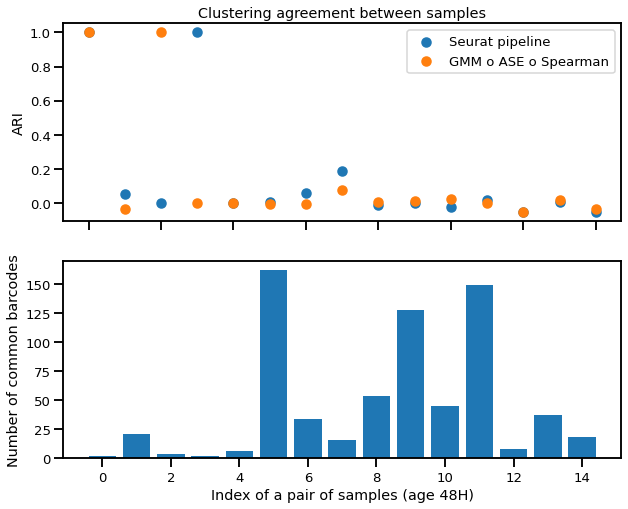

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(10,8))
ax = axs[0]
ax.scatter(range(len(seurat_ARI)), seurat_ARI, label='Seurat pipeline')
ax.scatter(range(len(new_ARI)), new_ARI, label='GMM o ASE o Spearman')
ax.legend()
ax.set(xticklabels='', ylabel='ARI', title='Clustering agreement between samples')

ax = axs[1]
ax.bar(range(len(new_ARI)), common_length)
ax.set(xlabel='Index of a pair of samples (age 48H)', ylabel='Number of common barcodes')
plt.show()


